In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from sklearn.metrics import f1_score, confusion_matrix
# List files in the MNIST directory
base_path = "/content/drive/MyDrive/MNIST_Dataset/MNIST_Dataset"
files = os.listdir(base_path)
print(files)


['t10k-labels.idx1-ubyte', 't10k-images.idx3-ubyte', 'train-images.idx3-ubyte', 'train-labels.idx1-ubyte', 'train-images-idx3-ubyte', 'train-labels-idx1-ubyte', 't10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte']


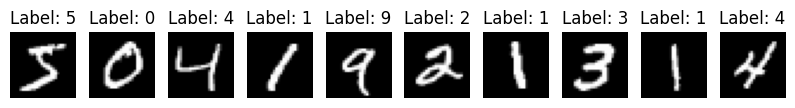

In [3]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from pathlib import Path

def load_images(file_path):
    with open(file_path, 'rb') as f:
        _, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)
    return images

def load_labels(file_path):
    with open(file_path, 'rb') as f:
        _, num_labels = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

# Define paths to your dataset files
base_path = Path("/content/drive/MyDrive/MNIST_Dataset/MNIST_Dataset")

train_images_path = base_path / "train-images.idx3-ubyte"
train_labels_path = base_path / "train-labels.idx1-ubyte"
test_images_path = base_path / "t10k-images.idx3-ubyte"
test_labels_path = base_path / "t10k-labels.idx1-ubyte"

# Load the data
train_images = load_images(train_images_path)
train_labels = load_labels(train_labels_path)
test_images = load_images(test_images_path)
test_labels = load_labels(test_labels_path)

def visualize_images(images, labels, num_images=10):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

visualize_images(train_images, train_labels, num_images=10)


In [4]:
print("Train images shape:", train_images.shape)  # Expected shape: (60000, 28, 28)
print("Train labels shape:", train_labels.shape)  # Expected shape: (60000,)
print("Test images shape:", test_images.shape)    # Expected shape: (10000, 28, 28)
print("Test labels shape:", test_labels.shape)    # Expected shape: (10000,)

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [5]:
train_labels[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [6]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [8]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 30),
            nn.ReLU(),
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
        )
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

model = NeuralNetwork().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
)


In [9]:
def train(dataloader, model, loss_fn, optimizer):
    for batch, data in enumerate(dataloader):
        X, y = data
        X, y = X.to(device), y.to(device)

        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print(f"loss: {loss.item()}")


In [10]:
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Create dataset
transform = transforms.ToTensor()
custom_dataset = ImageDataset(train_images, train_labels, transform=transform)

# Create DataLoader
train_dataloader = DataLoader(custom_dataset, batch_size=16, shuffle=True)

# Train the model
train(train_dataloader, model, loss_fn, optimizer)


loss: 2.3304221630096436
loss: 1.1733506917953491
loss: 0.6231756210327148
loss: 0.4474743604660034
loss: 0.6547170281410217
loss: 0.531148374080658
loss: 0.3851950168609619
loss: 0.6860077977180481
loss: 0.4526177942752838
loss: 0.16436204314231873
loss: 0.37381041049957275
loss: 0.25709593296051025
loss: 0.3492184579372406
loss: 0.3374687135219574
loss: 0.299214243888855
loss: 0.5754684209823608
loss: 0.24692827463150024
loss: 0.240234375
loss: 0.14391975104808807
loss: 0.38058850169181824
loss: 0.7588406801223755
loss: 0.1009213998913765
loss: 0.5087680220603943
loss: 0.10393978655338287
loss: 0.6512647271156311
loss: 0.12639640271663666
loss: 0.062007587403059006
loss: 0.4550916850566864
loss: 0.8610561490058899
loss: 0.0747249573469162
loss: 0.15187408030033112
loss: 0.1420908272266388
loss: 0.18258211016654968
loss: 0.28649047017097473
loss: 0.3766472637653351
loss: 0.06626907736063004
loss: 0.05211283266544342
loss: 0.1665954440832138


In [11]:
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix

# Evaluate the model and store layer outputs for t-SNE
model.eval()
all_predictions, all_labels = [], []
features, labels = [], []
total_samples, correct_predictions = 0, 0
test_dataset = ImageDataset(test_images, test_labels, transform=transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
with torch.no_grad():  # No need to calculate gradients during testing
    for X_batch, y_batch in test_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move batch to the appropriate device
        logits = model(X_batch)  # Forward pass to get logits

        # Apply softmax to get probabilities and obtain predictions
        pred_probab = F.softmax(logits, dim=1)
        y_pred = pred_probab.argmax(dim=1)

        # Store predictions and labels
        all_predictions.extend(y_pred.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

        # Extract activations from the 20-neuron layer for t-SNE
        flattened = model.flatten(X_batch)
        layer1_output = model.linear_relu_stack[0](flattened)  # First layer (30 neurons)
        layer1_output = model.linear_relu_stack[1](layer1_output)  # ReLU
        layer2_output = model.linear_relu_stack[2](layer1_output)  # Second layer (20 neurons)

        features.extend(layer2_output.cpu().numpy())
        labels.extend(y_batch.cpu().numpy())

        correct_predictions += (y_pred == y_batch).sum().item()
        total_samples += y_batch.size(0)

# Overall accuracy
accuracy_MLP = (correct_predictions / total_samples) * 100
f1_MLP = f1_score(all_labels, all_predictions, average='weighted')
cm_MLP = confusion_matrix(all_labels, all_predictions)

print(f"Accuracy: {accuracy_MLP:.2f}%")
print(f"F1-Score (MLP): {f1_MLP:.2f}")
print("Confusion Matrix (MLP):")
print(cm_MLP)

# Convert features and labels to numpy arrays for t-SNE processing
features_MLP = np.array(features)
labels_MLP = np.array(labels)


Accuracy: 93.62%
F1-Score (MLP): 0.94
Confusion Matrix (MLP):
[[ 954    1    1    0    1    7   10    2    4    0]
 [   0 1118    3    2    0    1    4    2    5    0]
 [   7    3  973    2    5    0   10   12   20    0]
 [   0    3   26  871    2   41    2   18   40    7]
 [   1    1    4    0  942    1    9    3    9   12]
 [   7    2    1   11    7  820   14    1   24    5]
 [   7    3    5    1   12   12  916    0    2    0]
 [   1    9   21    2    3    1    0  977    3   11]
 [   3    6   10    6   13   13    5   15  895    8]
 [   9    9    2    5   54    4    0   20   10  896]]


In [14]:
import torch
import torch.nn as nn
import numpy as np
from einops import rearrange
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Normalize coordinate map
def create_coordinate_map(img):
    if isinstance(img, np.ndarray):
        img = torch.from_numpy(img)
    height, width = img.shape
    w_coords = (torch.arange(width) / width - 0.5) * 2
    h_coords = (torch.arange(height) / height - 0.5) * 2
    w_coords = w_coords.repeat(height, 1).reshape(-1)
    h_coords = h_coords.repeat(width, 1).t().reshape(-1)
    X = torch.stack([h_coords, w_coords], dim=1).float().to(device)
    Y = rearrange(img, 'h w -> (h w)').float().to(device)
    return X, Y

# Define RFF Feature Transformation with Gaussian kernel
def create_gaussian_rff_features(X, num_features, sigma, device):
    n_features = X.shape[1]
    W = torch.randn(n_features, num_features, device=device) / sigma
    b = 2 * np.pi * torch.rand(num_features, device=device)
    Z = torch.cos(torch.matmul(X, W) + b) * (2.0 / np.sqrt(num_features))
    return Z

# Define RFF Feature Transformation with Polynomial kernel
def create_polynomial_rff_features(X, num_features, degree, device):
    n_samples, n_features = X.shape
    W = torch.randn(n_features, num_features, device=device) * (degree ** -0.5)
    b = 2 * np.pi * torch.rand(num_features, device=device)
    Z = torch.pow(torch.matmul(X, W), degree) * (2.0 / np.sqrt(num_features)) * torch.cos(torch.matmul(X, W) + b)
    return Z

# Function to normalize features
def normalize_features(features):
    scaler = StandardScaler()
    return torch.tensor(scaler.fit_transform(features.cpu()), device=device, dtype=torch.float32)

# Process all images separately with Gaussian RFF and store features
num_features = 3000  # Use 3000 features for RFF
train_X_gaussian_rff = []
for img in train_images:
    X, _ = create_coordinate_map(img)
    X_rff = create_gaussian_rff_features(X, num_features, sigma=0.008, device=device)
    train_X_gaussian_rff.append(X_rff.mean(dim=0))  # Averaging for compact representation
train_X_gaussian_rff = torch.stack(train_X_gaussian_rff)

# Normalize the Gaussian RFF features
train_X_gaussian_rff = normalize_features(train_X_gaussian_rff)

# Process all images separately with Polynomial RFF and store features
train_X_polynomial_rff = []
degree = 2  # You can change the degree as needed
for img in train_images:
    X, _ = create_coordinate_map(img)
    X_rff = create_polynomial_rff_features(X, num_features, degree, device)
    train_X_polynomial_rff.append(X_rff.mean(dim=0))
train_X_polynomial_rff = torch.stack(train_X_polynomial_rff)

# Normalize the Polynomial RFF features
train_X_polynomial_rff = normalize_features(train_X_polynomial_rff)

# Model Definition
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

# Initialize models
net_gaussian = LinearModel(num_features, 10).to(device)
net_polynomial = LinearModel(num_features, 10).to(device)

# Training setup
train_labels_tensor = torch.tensor(train_labels, device=device, dtype=torch.long)

def train_rflr(net, lr, X, Y, epochs, verbose=True):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
    return loss.item()

# Train model with Gaussian RFF
print("Training model with Gaussian RFF...")
train_rflr(net_gaussian, lr=1e-4, X=train_X_gaussian_rff, Y=train_labels_tensor, epochs=1000)

# Train model with Polynomial RFF
print("Training model with Polynomial RFF...")
train_rflr(net_polynomial, lr=1e-4, X=train_X_polynomial_rff, Y=train_labels_tensor, epochs=1000)

# Process test images with Gaussian RFF
test_X_gaussian_rff = []
for img in test_images:
    X, _ = create_coordinate_map(img)
    X_rff = create_gaussian_rff_features(X, num_features, sigma=0.008, device=device)
    test_X_gaussian_rff.append(X_rff.mean(dim=0))
test_X_gaussian_rff = torch.stack(test_X_gaussian_rff)

# Normalize the test Gaussian RFF features
test_X_gaussian_rff = normalize_features(test_X_gaussian_rff)

# Process test images with Polynomial RFF
test_X_polynomial_rff = []
for img in test_images:
    X, _ = create_coordinate_map(img)
    X_rff = create_polynomial_rff_features(X, num_features, degree, device)
    test_X_polynomial_rff.append(X_rff.mean(dim=0))
test_X_polynomial_rff = torch.stack(test_X_polynomial_rff)

# Normalize the test Polynomial RFF features
test_X_polynomial_rff = normalize_features(test_X_polynomial_rff)

# Ensure test_labels is a tensor
test_labels_tensor = torch.tensor(test_labels, device=device, dtype=torch.long)

# Evaluate the Gaussian RFF model
with torch.no_grad():
    test_outputs_gaussian = net_gaussian(test_X_gaussian_rff)
    predictions_gaussian = test_outputs_gaussian.argmax(dim=1)
    correct_gaussian = (predictions_gaussian == test_labels_tensor).sum().item()
    accuracy_gaussian = correct_gaussian / len(test_labels) * 100
    f1_gaussian = f1_score(test_labels_tensor.cpu(), predictions_gaussian.cpu(), average='weighted')
    cm_gaussian = confusion_matrix(test_labels_tensor.cpu(), predictions_gaussian.cpu())

print(f"Accuracy on the test set (Gaussian RFF): {accuracy_gaussian:.2f}%")
print(f"F1 Score (Gaussian RFF): {f1_gaussian:.4f}")
print(f"Confusion Matrix (Gaussian RFF):\n{cm_gaussian}")

# Evaluate the Polynomial RFF model
with torch.no_grad():
    test_outputs_polynomial = net_polynomial(test_X_polynomial_rff)
    predictions_polynomial = test_outputs_polynomial.argmax(dim=1)
    correct_polynomial = (predictions_polynomial == test_labels_tensor).sum().item()
    accuracy_polynomial = correct_polynomial / len(test_labels) * 100
    f1_polynomial = f1_score(test_labels_tensor.cpu(), predictions_polynomial.cpu(), average='weighted')
    cm_polynomial = confusion_matrix(test_labels_tensor.cpu(), predictions_polynomial.cpu())

print(f"Accuracy on the test set (Polynomial RFF): {accuracy_polynomial:.2f}%")
print(f"F1 Score (Polynomial RFF): {f1_polynomial:.4f}")
print(f"Confusion Matrix (Polynomial RFF):\n{cm_polynomial}")


Training model with Gaussian RFF...
Epoch 0, Loss: 2.449313
Epoch 100, Loss: 2.206862
Epoch 200, Loss: 2.119532
Epoch 300, Loss: 2.086506
Epoch 400, Loss: 2.073722
Epoch 500, Loss: 2.068768
Epoch 600, Loss: 2.066865
Epoch 700, Loss: 2.066132
Epoch 800, Loss: 2.065835
Epoch 900, Loss: 2.065696
Training model with Polynomial RFF...
Epoch 0, Loss: 2.450697
Epoch 100, Loss: 2.205847
Epoch 200, Loss: 2.117230
Epoch 300, Loss: 2.083698
Epoch 400, Loss: 2.070731
Epoch 500, Loss: 2.065708
Epoch 600, Loss: 2.063770
Epoch 700, Loss: 2.063014
Epoch 800, Loss: 2.062701
Epoch 900, Loss: 2.062554
Accuracy on the test set (Gaussian RFF): 9.63%
F1 Score (Gaussian RFF): 0.0963
Confusion Matrix (Gaussian RFF):
[[ 99 109  90 105  97  96  87 110  87 100]
 [111 118 115 128  89  95 122 142  92 123]
 [101 116  99 108  95  92  88 110  97 126]
 [ 85 132 114 113  98  85 101  98  79 105]
 [ 86 112  88 118  95  73  92 117  98 103]
 [ 78 107  90 113  76  78  85  91  94  80]
 [ 88 120  94  83 108  76  84 117  95  9

In [16]:
import torch
import torch.nn as nn
import numpy as np
from einops import rearrange
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Normalize coordinate map
def create_coordinate_map(img):
    if isinstance(img, np.ndarray):
        img = torch.from_numpy(img)
    height, width = img.shape
    w_coords = (torch.arange(width) / width - 0.5) * 2
    h_coords = (torch.arange(height) / height - 0.5) * 2
    w_coords = w_coords.repeat(height, 1).reshape(-1)
    h_coords = h_coords.repeat(width, 1).t().reshape(-1)
    X = torch.stack([h_coords, w_coords], dim=1).float().to(device)
    Y = rearrange(img, 'h w -> (h w)').float().to(device)
    return X, Y

# Define RFF Feature Transformation with Gaussian kernel
def create_gaussian_rff_features(X, num_features, sigma, device):
    n_features = X.shape[1]
    W = torch.randn(n_features, num_features, device=device) / sigma
    b = 2 * np.pi * torch.rand(num_features, device=device)
    Z = torch.cos(torch.matmul(X, W) + b) * (2.0 / np.sqrt(num_features))
    return Z

# Define RFF Feature Transformation with Polynomial kernel
def create_polynomial_rff_features(X, num_features, degree, device):
    n_samples, n_features = X.shape
    W = torch.randn(n_features, num_features, device=device) * (degree ** -0.5)
    b = 2 * np.pi * torch.rand(num_features, device=device)
    Z = torch.pow(torch.matmul(X, W), degree) * (2.0 / np.sqrt(num_features)) * torch.cos(torch.matmul(X, W) + b)
    return Z

# Function to normalize features
def normalize_features(features):
    scaler = StandardScaler()
    return torch.tensor(scaler.fit_transform(features.cpu()), device=device, dtype=torch.float32)

# Process all images separately with Gaussian RFF and store features
num_features = 5000  # Use 3000 features for RFF
train_X_gaussian_rff = []
for img in train_images:
    X, _ = create_coordinate_map(img)
    X_rff = create_gaussian_rff_features(X, num_features, sigma=0.008, device=device)
    train_X_gaussian_rff.append(X_rff.mean(dim=0))  # Averaging for compact representation
train_X_gaussian_rff = torch.stack(train_X_gaussian_rff)

# Normalize the Gaussian RFF features
train_X_gaussian_rff = normalize_features(train_X_gaussian_rff)

# Process all images separately with Polynomial RFF and store features
train_X_polynomial_rff = []
degree = 2  # You can change the degree as needed
for img in train_images:
    X, _ = create_coordinate_map(img)
    X_rff = create_polynomial_rff_features(X, num_features, degree, device)
    train_X_polynomial_rff.append(X_rff.mean(dim=0))
train_X_polynomial_rff = torch.stack(train_X_polynomial_rff)

# Normalize the Polynomial RFF features
train_X_polynomial_rff = normalize_features(train_X_polynomial_rff)

# Model Definition
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

# Initialize models
net_gaussian = LinearModel(num_features, 10).to(device)
net_polynomial = LinearModel(num_features, 10).to(device)

# Training setup
train_labels_tensor = torch.tensor(train_labels, device=device, dtype=torch.long)

def train_rflr(net, lr, X, Y, epochs, verbose=True):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
    return loss.item()

# Train model with Gaussian RFF
print("Training model with Gaussian RFF...")
train_rflr(net_gaussian, lr=1e-4, X=train_X_gaussian_rff, Y=train_labels_tensor, epochs=1000)

# Train model with Polynomial RFF
print("Training model with Polynomial RFF...")
train_rflr(net_polynomial, lr=1e-4, X=train_X_polynomial_rff, Y=train_labels_tensor, epochs=1000)

# Process test images with Gaussian RFF
test_X_gaussian_rff = []
for img in test_images:
    X, _ = create_coordinate_map(img)
    X_rff = create_gaussian_rff_features(X, num_features, sigma=0.008, device=device)
    test_X_gaussian_rff.append(X_rff.mean(dim=0))
test_X_gaussian_rff = torch.stack(test_X_gaussian_rff)

# Normalize the test Gaussian RFF features
test_X_gaussian_rff = normalize_features(test_X_gaussian_rff)

# Process test images with Polynomial RFF
test_X_polynomial_rff = []
for img in test_images:
    X, _ = create_coordinate_map(img)
    X_rff = create_polynomial_rff_features(X, num_features, degree, device)
    test_X_polynomial_rff.append(X_rff.mean(dim=0))
test_X_polynomial_rff = torch.stack(test_X_polynomial_rff)

# Normalize the test Polynomial RFF features
test_X_polynomial_rff = normalize_features(test_X_polynomial_rff)

# Ensure test_labels is a tensor
test_labels_tensor = torch.tensor(test_labels, device=device, dtype=torch.long)

# Evaluate the Gaussian RFF model
with torch.no_grad():
    test_outputs_gaussian = net_gaussian(test_X_gaussian_rff)
    predictions_gaussian = test_outputs_gaussian.argmax(dim=1)
    correct_gaussian = (predictions_gaussian == test_labels_tensor).sum().item()
    accuracy_gaussian = correct_gaussian / len(test_labels) * 100
    f1_gaussian = f1_score(test_labels_tensor.cpu(), predictions_gaussian.cpu(), average='weighted')
    cm_gaussian = confusion_matrix(test_labels_tensor.cpu(), predictions_gaussian.cpu())

print(f"Accuracy on the test set (Gaussian RFF): {accuracy_gaussian:.2f}%")
print(f"F1 Score (Gaussian RFF): {f1_gaussian:.4f}")
print(f"Confusion Matrix (Gaussian RFF):\n{cm_gaussian}")

# Evaluate the Polynomial RFF model
with torch.no_grad():
    test_outputs_polynomial = net_polynomial(test_X_polynomial_rff)
    predictions_polynomial = test_outputs_polynomial.argmax(dim=1)
    correct_polynomial = (predictions_polynomial == test_labels_tensor).sum().item()
    accuracy_polynomial = correct_polynomial / len(test_labels) * 100
    f1_polynomial = f1_score(test_labels_tensor.cpu(), predictions_polynomial.cpu(), average='weighted')
    cm_polynomial = confusion_matrix(test_labels_tensor.cpu(), predictions_polynomial.cpu())

print(f"Accuracy on the test set (Polynomial RFF): {accuracy_polynomial:.2f}%")
print(f"F1 Score (Polynomial RFF): {f1_polynomial:.4f}")
print(f"Confusion Matrix (Polynomial RFF):\n{cm_polynomial}")


Training model with Gaussian RFF...
Epoch 0, Loss: 2.449879
Epoch 100, Loss: 2.096904
Epoch 200, Loss: 1.978184
Epoch 300, Loss: 1.932942
Epoch 400, Loss: 1.914492
Epoch 500, Loss: 1.906799
Epoch 600, Loss: 1.903593
Epoch 700, Loss: 1.902262
Epoch 800, Loss: 1.901699
Epoch 900, Loss: 1.901443
Training model with Polynomial RFF...
Epoch 0, Loss: 2.446327
Epoch 100, Loss: 2.093011
Epoch 200, Loss: 1.975050
Epoch 300, Loss: 1.930790
Epoch 400, Loss: 1.913091
Epoch 500, Loss: 1.905885
Epoch 600, Loss: 1.902972
Epoch 700, Loss: 1.901808
Epoch 800, Loss: 1.901339
Epoch 900, Loss: 1.901137
Accuracy on the test set (Gaussian RFF): 9.87%
F1 Score (Gaussian RFF): 0.0986
Confusion Matrix (Gaussian RFF):
[[ 94 135 100  89  86  92 109  87  89  99]
 [101 134 105 131 101  95 109 128 119 112]
 [133 116 100  98  89  82  91 112 101 110]
 [102 102  87 115 107 104  95 102  91 105]
 [ 98 114  97  96  87  96 100  97 102  95]
 [ 87 106  97 101  79  74  85  82  81 100]
 [ 88 107  91 127  89  84  94 103  76  9

In [15]:
print(f"Accuracy: {accuracy_gaussian:.2f}%")
print(f"F1-Score (RFF LR): {f1_gaussian:.2f}")
print("Confusion Matrix (RFF LR):")
print(cm_gaussian)

print(f"Accuracy on the test set (MLP): {accuracy_MLP:.2f}%")
print(f"F1-Score (MLP): {f1_MLP:.2f}")
print("Confusion Matrix (MLP):")
print(cm_MLP)

Accuracy: 9.63%
F1-Score (RFF LR): 0.10
Confusion Matrix (RFF LR):
[[ 99 109  90 105  97  96  87 110  87 100]
 [111 118 115 128  89  95 122 142  92 123]
 [101 116  99 108  95  92  88 110  97 126]
 [ 85 132 114 113  98  85 101  98  79 105]
 [ 86 112  88 118  95  73  92 117  98 103]
 [ 78 107  90 113  76  78  85  91  94  80]
 [ 88 120  94  83 108  76  84 117  95  93]
 [112 112 102 114 109  89 101  89 109  91]
 [ 89 134  96 101  90  87  81 108  80 108]
 [ 83 111  92 117  87 106  85 107 113 108]]
Accuracy on the test set (MLP): 93.62%
F1-Score (MLP): 0.94
Confusion Matrix (MLP):
[[ 954    1    1    0    1    7   10    2    4    0]
 [   0 1118    3    2    0    1    4    2    5    0]
 [   7    3  973    2    5    0   10   12   20    0]
 [   0    3   26  871    2   41    2   18   40    7]
 [   1    1    4    0  942    1    9    3    9   12]
 [   7    2    1   11    7  820   14    1   24    5]
 [   7    3    5    1   12   12  916    0    2    0]
 [   1    9   21    2    3    1    0  977    3 

In [17]:
import numpy as np

# Function to print confusion matrix analysis in sorted order
def analyze_confusion_matrix(cm):
    class_names = [str(i) for i in range(10)]
    print("Confusion Matrix:")
    print(cm)

    confusion_list = []  # List to hold (confusion_count, digit1, digit2) tuples

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:  # Skip the diagonal (correct predictions)
                confusion_list.append((cm[i, j], i, j))

    # Sort the confusion list in decreasing order based on confusion count
    confusion_list.sort(reverse=True, key=lambda x: x[0])

    # Print the sorted confusions
    for count, digit1, digit2 in confusion_list:
        print(f"Digit {digit1} is confused with Digit {digit2}: {count} times")

# Analyze confusion matrix for MLP
print("MLP Model Confusion Matrix Analysis:")
analyze_confusion_matrix(cm_MLP)


MLP Model Confusion Matrix Analysis:
Confusion Matrix:
[[ 954    1    1    0    1    7   10    2    4    0]
 [   0 1118    3    2    0    1    4    2    5    0]
 [   7    3  973    2    5    0   10   12   20    0]
 [   0    3   26  871    2   41    2   18   40    7]
 [   1    1    4    0  942    1    9    3    9   12]
 [   7    2    1   11    7  820   14    1   24    5]
 [   7    3    5    1   12   12  916    0    2    0]
 [   1    9   21    2    3    1    0  977    3   11]
 [   3    6   10    6   13   13    5   15  895    8]
 [   9    9    2    5   54    4    0   20   10  896]]
Digit 9 is confused with Digit 4: 54 times
Digit 3 is confused with Digit 5: 41 times
Digit 3 is confused with Digit 8: 40 times
Digit 3 is confused with Digit 2: 26 times
Digit 5 is confused with Digit 8: 24 times
Digit 7 is confused with Digit 2: 21 times
Digit 2 is confused with Digit 8: 20 times
Digit 9 is confused with Digit 7: 20 times
Digit 3 is confused with Digit 7: 18 times
Digit 8 is confused with Di

So, seeing both of them, we can clearly say that RF+LR isn't actually is properly learning, because there are so many strokes and many, which needed very high dimensionality, even that is not able to learn effectively. I even changed the kernels, both gaussian and polynomial, but still there is no use. I had used both 3000 and 5000 feature space, but there is negligable increase showing that this is not learning properly. We can also this in the losses.

As we see, (4,9) has highest similarlity. We can also see them very close in T-SNE plot below. Also (3,5), (3,8) are next closer features. We can see their closeness in plot. In 2D we may see that they may look farther, but in higher dimensions, they maybe are closer.

Trained Model t-SNE:


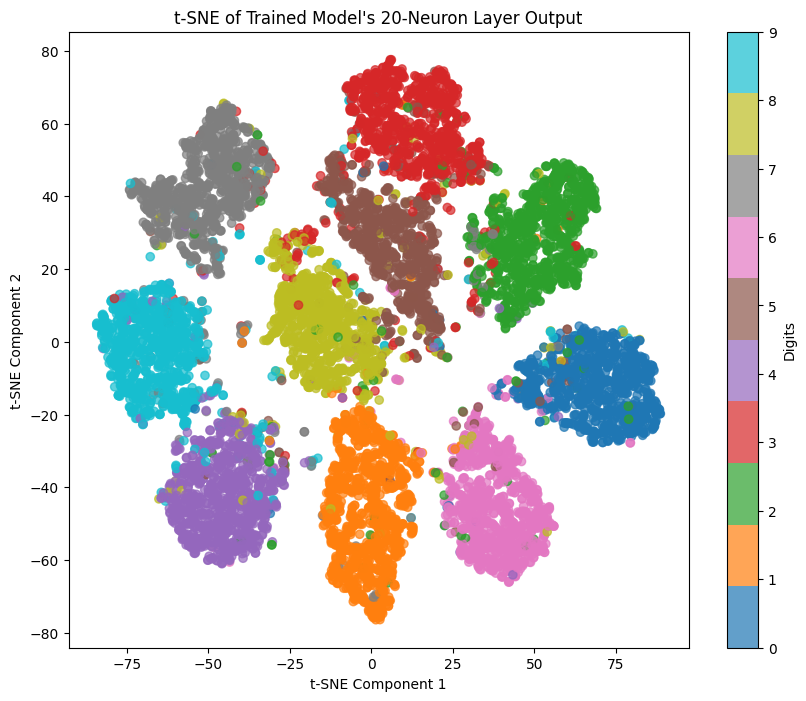

Untrained Model t-SNE:


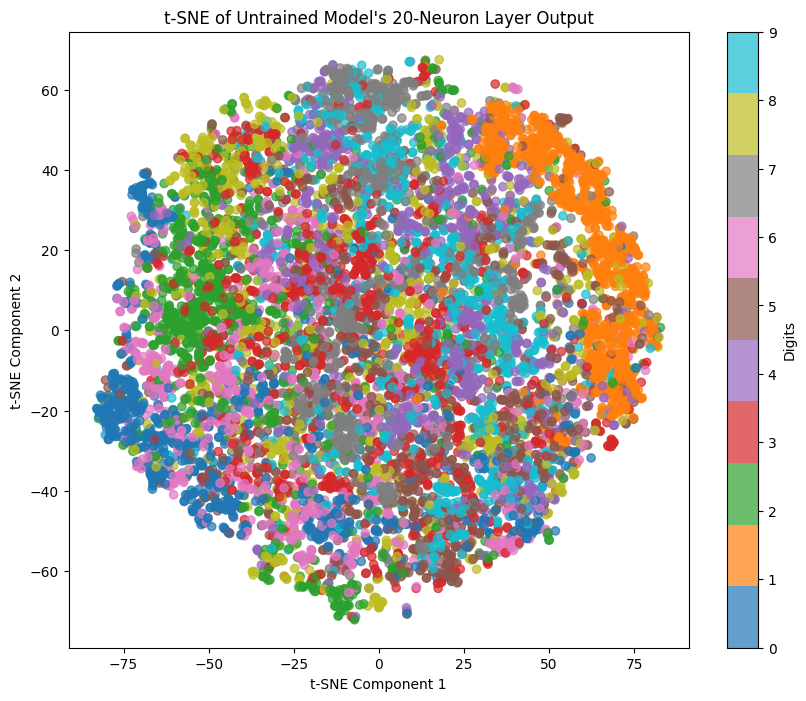

t-SNE of Actual Test Images:


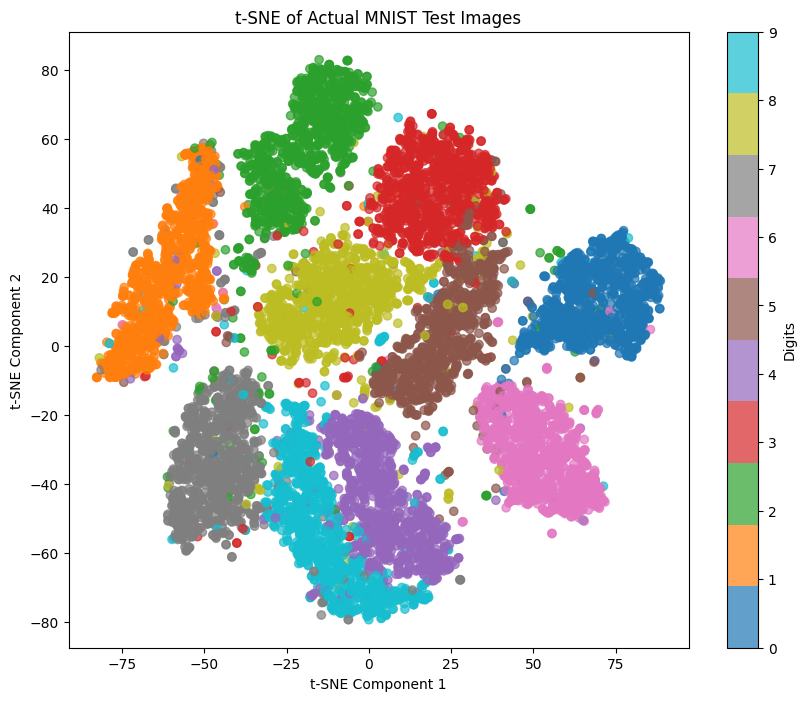

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix

# Define function to extract layer outputs and plot t-SNE
def plot_tsne(model, dataloader, title="t-SNE of 20-Neuron Layer Output"):
    model.eval()
    features, labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass up to the 20-neuron layer
            flattened = model.flatten(X_batch)
            layer1_output = model.linear_relu_stack[0](flattened)
            layer1_output = model.linear_relu_stack[1](layer1_output)
            layer2_output = model.linear_relu_stack[2](layer1_output)

            features.extend(layer2_output.cpu().numpy())
            labels.extend(y_batch.cpu().numpy())

    # Convert to numpy for t-SNE
    features = np.array(features)
    labels = np.array(labels)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    features_2d = tsne.fit_transform(features)

    # Plot t-SNE
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(10), label='Digits')
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title(title)
    plt.show()

def plot_tsne_raw_data(dataloader, title="t-SNE of Actual Test Images"):
    features, labels = [], []

    for X_batch, y_batch in dataloader:
        features.extend(X_batch.view(X_batch.size(0), -1).cpu().numpy())  # Flatten the images
        labels.extend(y_batch.cpu().numpy())

    # Convert to numpy for t-SNE
    features = np.array(features)
    labels = np.array(labels)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    features_2d = tsne.fit_transform(features)

    # Plot t-SNE
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(10), label='Digits')
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title(title)
    plt.show()

# Plot t-SNE for the trained model
print("Trained Model t-SNE:")
plot_tsne(model, test_dataloader, title="t-SNE of Trained Model's 20-Neuron Layer Output")

# Initialize an untrained model
untrained_model = NeuralNetwork().to(device)

# Plot t-SNE for the untrained model
print("Untrained Model t-SNE:")
plot_tsne(untrained_model, test_dataloader, title="t-SNE of Untrained Model's 20-Neuron Layer Output")

print("t-SNE of Actual Test Images:")
plot_tsne_raw_data(test_dataloader, title="t-SNE of Actual MNIST Test Images")


So, we see that for untrained model when we see T-SNE, we see that this has very poor classification in learning the actual dataset. This is due to random initialization in the model or it is simply guessing the outputs. Whereas our learned model learns really well on the dataset and is very accurate.  

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.2MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 192kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.53MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 3.28MB/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

MNIST t-SNE:


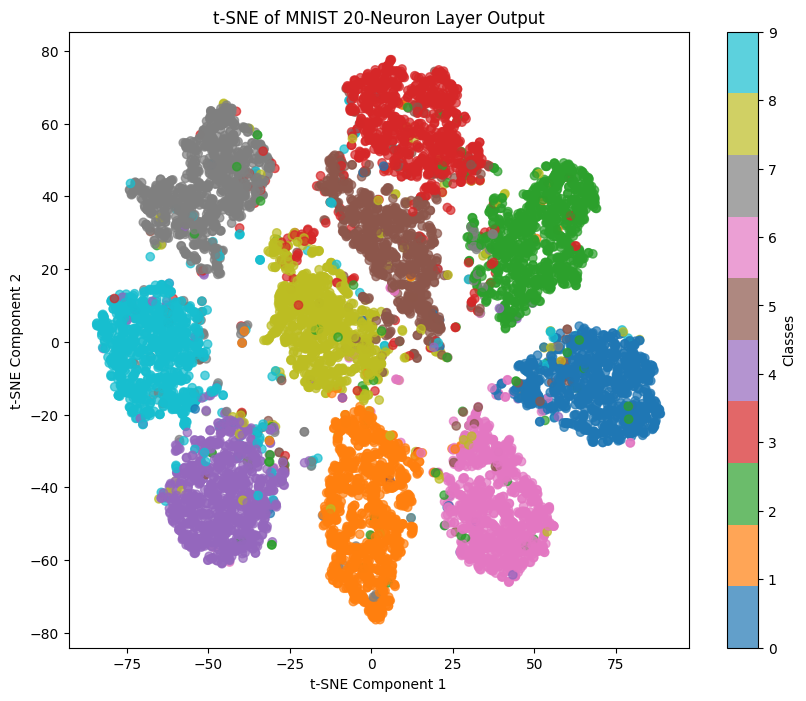

Fashion-MNIST t-SNE:


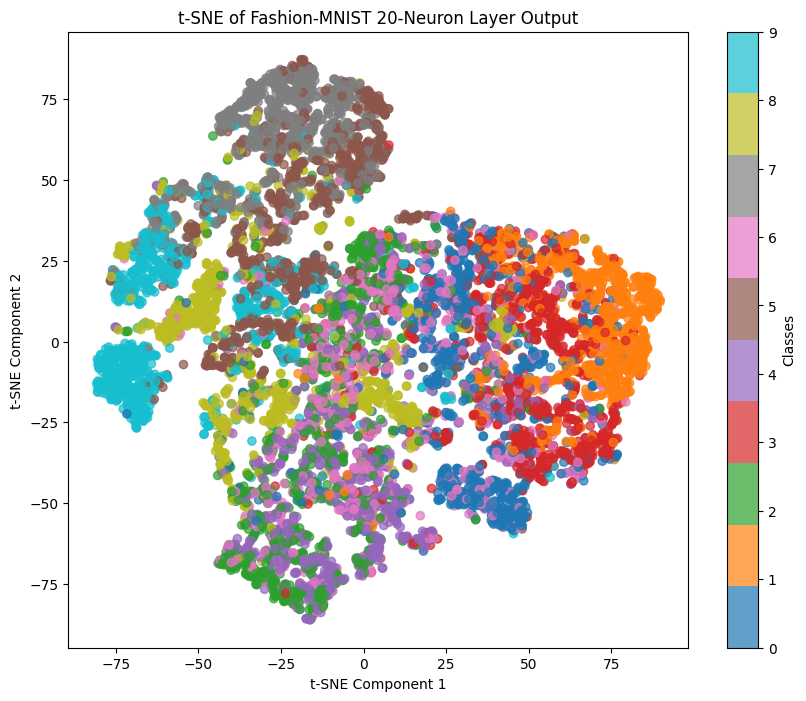

In [ ]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define function to extract and plot t-SNE for a given dataloader
def extract_tsne(model, dataloader, title="t-SNE of 20-Neuron Layer Output"):
    model.eval()
    features, labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass up to the 20-neuron layer
            flattened = model.flatten(X_batch)
            layer1_output = model.linear_relu_stack[0](flattened)
            layer1_output = model.linear_relu_stack[1](layer1_output)
            layer2_output = model.linear_relu_stack[2](layer1_output)  # 20-neuron layer output

            features.extend(layer2_output.cpu().numpy())
            labels.extend(y_batch.cpu().numpy())

    # Convert features and labels to numpy arrays
    features = np.array(features)
    labels = np.array(labels)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    features_2d = tsne.fit_transform(features)

    # Plot t-SNE
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(10), label='Classes')
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title(title)
    plt.show()

# Prepare Fashion-MNIST data with the same transforms
fashion_mnist_test = datasets.FashionMNIST(root='data', train=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Same normalization as MNIST
]), download=True)
fashion_mnist_dataloader = DataLoader(fashion_mnist_test, batch_size=16, shuffle=False)

# Plot t-SNE for MNIST using test_dataloader
print("MNIST t-SNE:")
extract_tsne(model, test_dataloader, title="t-SNE of MNIST 20-Neuron Layer Output")

# Plot t-SNE for Fashion-MNIST
print("Fashion-MNIST t-SNE:")
extract_tsne(model, fashion_mnist_dataloader, title="t-SNE of Fashion-MNIST 20-Neuron Layer Output")


We see that the Fashion MNIST dataset performs poorly when we train the MNIST model on the Fashion MNIST dataset because a model trained on the MNIST dataset learns how to learn from curves, loops, and such things in the images. Whereas, fashion MNIST is not like that, it has visual structures which has little to no overlap to the features learnt using MNIST dataset. So, we see such poor embedding of fashion-MNIST dataset. Let us see accuaracy and other parameters as well to see how is it predicting on this model.

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations to match your MNIST preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize similar to MNIST if it was used
])

# Load Fashion-MNIST test dataset
fashion_mnist_test = datasets.FashionMNIST(root='data', train=False, transform=transform, download=True)
fashion_mnist_dataloader = DataLoader(fashion_mnist_test, batch_size=16, shuffle=False)

# Evaluate on Fashion-MNIST using the trained MLP model
model.eval()
fashion_predictions, fashion_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in fashion_mnist_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move batch to the appropriate device

        # Forward pass through the model
        logits = model(X_batch)
        y_pred = logits.argmax(dim=1)

        # Collect predictions and true labels
        fashion_predictions.extend(y_pred.cpu().numpy())
        fashion_labels.extend(y_batch.cpu().numpy())

# Optional: Calculate accuracy, F1, or confusion matrix
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Convert to numpy arrays for evaluation
fashion_predictions = np.array(fashion_predictions)
fashion_labels = np.array(fashion_labels)

# Accuracy
accuracy_fashion = accuracy_score(fashion_labels, fashion_predictions) * 100
f1_fashion = f1_score(fashion_labels, fashion_predictions, average='weighted')
cm_fashion = confusion_matrix(fashion_labels, fashion_predictions)

print(f"Fashion-MNIST Accuracy: {accuracy_fashion:.2f}%")
print(f"Fashion-MNIST F1-Score: {f1_fashion:.2f}")
print("Fashion-MNIST Confusion Matrix:")
print(cm_fashion)


Fashion-MNIST Accuracy: 6.20%
Fashion-MNIST F1-Score: 0.04
Fashion-MNIST Confusion Matrix:
[[  1   0   3   1 413   6 337   3  60 176]
 [  0   0   0   0 181   0 792   0   0  27]
 [ 13   0   6   6 373   1 466   3  31 101]
 [  0   0   0   0 385   0 435   0   2 178]
 [  6   0   6   2 317   0 336   0  25 308]
 [  1   0  39   0 696  85 167   9   0   3]
 [  3   0  11   1 514   2 178   2  35 254]
 [  0   0  42   1 909   1  47   0   0   0]
 [  4   0  97  18 602  38  30  35  15 161]
 [  0   1 284   0 143 197 352   1   4  18]]


Hence, we see a really poor output here.